In [2]:
import requests
import pandas as pd

In [3]:
GRT_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet-test"
def grt_query(query):
    r = requests.post(GRT_ENDPOINT, json={'query': query})
    return r.json()['data']

In [4]:
GRT_POOL_QUERY = """
{pools(first: 1000) {
  name
  isV2
  id
}}"""
pools = grt_query(GRT_POOL_QUERY)['pools']

In [5]:
pools[0]

{'name': 'Curve.fi Factory USD Metapool: RC_bBADGER_5_DAI_2021_6_30',
 'isV2': False,
 'id': '0x0043fcb34e7470130fde28198571dee092c70bd7'}

In [6]:
GRT_SWAP_QUERY = """
{pool(id: "%s") {
  id
  swapEvents(first: 1000) {
  	buyer
    amountSoldUSD
    amountBoughtUSD
    timestamp
  }
}
}
"""

In [122]:
import concurrent.futures

queries = [GRT_SWAP_QUERY % pool['id'] for pool in pools]

with concurrent.futures.ThreadPoolExecutor() as executor: # In this case thread would be better
    results = executor.map(grt_query,queries)

In [123]:
results = list(results)

In [395]:
df = pd.DataFrame([{'pool': result['pool']['id']} | event for result in results for event in result['pool']['swapEvents']])
df

,pool,buyer,amountSoldUSD,amountBoughtUSD,timestamp
0,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1156.462792818217770213632145845818,1156.972907225342548345,1622720984
1,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,3282.297886475391170943976321851474,3282.056108423886254264,1622586311
2,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,8465.250366468469231337770147998399,8497.878254552045245019,1622519689
3,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,57272.15063092577379744151392792888,57273.51675837831579106,1622601370
4,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1071.526675437278290375,1068.220145590055428692,1622511272
...,...,...,...,...,...
92655,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,2189.429248938073016775352388563751,2202.431101320858537121875249897464,1627311357
92656,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,71319.50497530878551791964008080387,71740.182204653372699629,1625099676
92657,0xfe97d8f55884186e50aedba306ad553911a26a24,0x2d25461573c7de76e14654b7de49b046f7b77379,13003.15231675174989566459268387968,13033.966237,1627605453
92658,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,556.2058593777106616121392333048901,561.0250617407030456817117623494544,1625953375


In [396]:
df[df['buyer'] == '0x9008d19f58aabd9ed0d60971565aa8510560ab41']

,pool,buyer,amountSoldUSD,amountBoughtUSD,timestamp


In [228]:
df['volume'] = (df['amountSoldUSD'].astype(float) + df['amountBoughtUSD'].astype(float)) / 2
df.drop(['amountSoldUSD', 'amountBoughtUSD'], axis=1, inplace=True)
df

,pool,buyer,timestamp,volume
0,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622720984,1156.72
1,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622586311,3282.18
2,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622519689,8481.56
3,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622601370,57272.83
4,0x0043fcb34e7470130fde28198571dee092c70bd7,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1622511272,1069.87
...,...,...,...,...
92655,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1627311357,2195.93
92656,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1625099676,71529.84
92657,0xfe97d8f55884186e50aedba306ad553911a26a24,0x2d25461573c7de76e14654b7de49b046f7b77379,1627605453,13018.56
92658,0xfe97d8f55884186e50aedba306ad553911a26a24,0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d,1625953375,558.62


In [209]:
df[df['timestamp'].astype(int) > 1656610000]['buyer'].value_counts()[:50]

0xf2f400c138f9fb900576263af0bc7fcde2b1b8a8    586
0xeef86c2e49e11345f1a693675df9a38f7d880c8f    519
0xdef171fe48cf0115b1d80b88dc8eab59176fee57    426
0xa1006d0051a35b0000f961a8000000009ea8d2db    410
0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7    332
0xec001d0000004536cad29291f4000000d029abb2    260
0x5f62593c70069abb35dfe2b63db969e8906609d6    258
0x00000000c2cf7648c169b25ef1c217864bfa38cc    190
0x0000000000007f150bd6f54c40a34d7c3d5e9f56    187
0xe4000004000bd8006e00720000d27d1fa000d43e    178
0x45716d9eddbc332df1d42b9f540fbebed671b20f    152
0x220bda5c8994804ac96ebe4df184d25e5c2196d4    146
0x563bdabaa8846ec445b25bfbed88d160890a02ed    140
0x000000000dfde7deaf24138722987c9a6991e2d4    126
0x22c4f485ccf48070b266bada8d97eef068dd2404    125
0x288931fa76d7b0482f0fd0bca9a50bf0d22b9fef    121
0x0eae044f00b0af300500f090ea00027097d03000    104
0x22f9dcf4647084d6c31b2765f6910cd85c178c18    102
0xb23dc3f00856288cd7b6bde5d06159f01b75aa4c     93
0xf6d78d9c50ffbc2917e374fd185b8ff89c55effc     88


In [126]:
paraswap = ['0xdef171fe48cf0115b1d80b88dc8eab59176fee57',
                   '0x1bd435f3c054b6e901b7b108a0ab7617c808677b',
           '0xf90e98f3d8dce44632e5020abf2e122e0f99dfab']

zerox = [    '0xdef1c0ded9bec7f1a1670819833240f027b25eff',
    '0x22f9dcf4647084d6c31b2765f6910cd85c178c18',
        '0x561b94454b65614ae3db0897b74303f4acf7cc75']

oneinch = ['0x1111111254fb6c44bac0bed2854e76f90643097d',
           '0x11111112542d85b3ef69ae05771c2dccff4faa26',
           '0x11111254369792b2ca5d084ab5eea397ca8fa48b',
           '0xdb38ae75c5f44276803345f7f02e95a0aeef5944',
    '0xfd3dfb524b2da40c8a6d703c62be36b5d8540626', 
    '0xc176761d388caf2f56cf03329d82e1e7c48ae09c', 
    '0x7c6ce24d013cd4ddf4c193ce318e3d5533a33f42', 
    '0x27239549dd40e1d60f5b80b0c4196923745b1fd2',
    '0xec193b3d86657ab0dcce9f33641cb7da6acefb0c',
    '0x220bda5c8994804ac96ebe4df184d25e5c2196d4',
    '0xe069cb01d06ba617bcdf789bf2ff0d5e5ca20c71',
    '0x0bf16c34b38648bb08deacf4dd4b239c44bb33c1',
           '0xd47140f6ab73f6d6b6675fb1610bb5e9b5d96fe5',
           '0xf2f400c138f9fb900576263af0bc7fcde2b1b8a8',
           # PMM
           # https://dune.com/queries/16257/32751
           '0x56178a0d5f301baf6cf3e1cd53d9863437345bf9',
 '0xb3c839dbde6b96d37c56ee4f9dad3390d49310aa',
 '0x632da2cb89e08449c75e7a4e022189e3d6af8a2b',
 '0xa5d07e978398eb1715056d3ca5cb31035c02fdad',
 '0x945bcf562085de2d5875b9e2012ed5fd5cfab927',
 '0x0000006daea1723962647b7e189d311d757fb793',
 '0x00000000ae347930bd1e7b0f35588b92280f9e75',
 '0xe2e3441004e7d377a2d97142e75d465e0dd36af9',
 '0x69b7dee444e6977bd8d62a86a8c8e9976dcbe4b7',
 '0x9acf7784929e012f76421414cc3d85559c6fdbb5',
 '0xb398ffef80144095b8712c70a0c09886c8151feb'
]

bots = [ '0xeef86c2e49e11345f1a693675df9a38f7d880c8f',
    '0xec001d0000004536cad29291f4000000d029abb2',
    '0xa1006d0051a35b0000f961a8000000009ea8d2db',
    '0x0000000000007f150bd6f54c40a34d7c3d5e9f56',
    '0x45716d9eddbc332df1d42b9f540fbebed671b20f',
    '0x1c073d5045b1abb6924d5f0f8b2f667b1653a4c3',
    '0x00000000c2cf7648c169b25ef1c217864bfa38cc',
        '0xb23dc3f00856288cd7b6bde5d06159f01b75aa4c',
        '0xa10fca31a2cb432c9ac976779dc947cfdb003ef0',
        '0x5f62593c70069abb35dfe2b63db969e8906609d6',
        '0x83a30b9c73de15560aa02a18964c45ad7a41d88e',
        '0x2057cfb9fd11837d61b294d514c5bd03e5e7189a',
        '0x000000000dfde7deaf24138722987c9a6991e2d4'
]

curve = ['0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7', 
         '0x2393c368c70b42f055a4932a3fbec2ac9c548011',
        '0x5d0f47b32fdd343bfa74ce221808e2abe4a53827',
        '0xfa9a30350048b2bf66865ee20363067c66f67e58',
        '0xc5fa220347375ac4f91f9e4a4aab362f22801504',
        '0xd1602f68cc7c4c7b59d686243ea35a9c73b0c6a2',
        '0x73ab2bd10ad10f7174a1ad5afae3ce3d991c5047']

aggregators = dict(zip(paraswap, ['Paraswap'] * len(paraswap))) | dict(zip(zerox, ['ZeroX'] * len(zerox))) | dict(zip(oneinch, ['1inch'] * len(oneinch))) | dict(zip(bots, ['Bots'] * len(bots))) | dict(zip(curve, ['Curve exchange'] * len(curve)))

aggregators['0x3a3ae0f08caf7c267305b99b2ce6780bdeefc25d'] = 'YieldFarming.insure'
aggregators['0x0000006daea1723962647b7e189d311d757fb793'] = 'Wintermute'
aggregators['0x6b44d94ecdfaf0cb00def55212e226603bb68793'] = 'MIM/UST Swapper'
#aggregators['0x0959158b6040d32d04c301a72cbfd6b39e21c9ae'] = 'Curve Fee Burning'
#aggregators['0x39eac46a11d7f5111652fc9ebdfb5f8e737c2bb5'] = 'Curve Fee Burning'

In [127]:
from web3 import Web3
import os
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
w3 = Web3(Web3.HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [128]:
def tag_aggregator(address):
    global aggregators
    if address in aggregators:
        return aggregators[address]
    else:
        is_eoa = w3.eth.getCode(Web3.toChecksumAddress(address)).hex()
        if is_eoa == '0x':
            aggregators[address] = "Others (EOA)"
            return "Others (EOA)"
        else:
            aggregators[address] = "Others (SC)"
            return "Others (SC)"

In [129]:
with concurrent.futures.ThreadPoolExecutor() as executor: # In this case thread would be better
    wallets = executor.map(tag_aggregator,df['buyer'].unique().tolist())

In [229]:
df['buyer'] = df['buyer'].apply(lambda x: aggregators[x] if x in aggregators else x)
df_chart = df.copy()

In [230]:
df['buyer'].value_counts()[:20]

Others (EOA)           32951
Bots                   22151
Others (SC)            13338
1inch                  11128
Curve exchange          5026
Paraswap                3597
ZeroX                   3069
YieldFarming.insure     1112
MIM/UST Swapper          288
Name: buyer, dtype: int64

In [231]:
WEEK = 3600 * 24 * 7
df_chart['timestamp'] = df_chart['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'],unit='s')

In [232]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [233]:
df_chart.groupby(['timestamp', 'buyer']).sum()

volume
timestamp  buyer                     
2020-10-29 Bots              57192.92
           Curve exchange  2996423.62
           Others (EOA)   15150813.60
           Others (SC)    11226295.66
           ZeroX            425854.88
...                               ...
2022-07-21 Curve exchange   194337.45
           Others (EOA)    2010777.84
           Others (SC)     1505805.46
           Paraswap          29686.84
           ZeroX            314534.52

[660 rows x 1 columns]

In [216]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [234]:
chart_data = df_chart.pivot_table('volume', ['timestamp'], 'buyer', aggfunc='sum').fillna(0)

In [235]:
chart_data

buyer,1inch,Bots,Curve exchange,MIM/UST Swapper,Others (EOA),Others (SC),Paraswap,YieldFarming.insure,ZeroX
timestamp,,,,,,,,,
2020-10-29,0.00,57192.92,2996423.62,0.00,15150813.60,11226295.66,0.00,0.00,425854.88
2020-11-05,0.00,84694.02,244623.46,0.00,36686988.06,27738691.52,0.00,0.00,3274590.45
2020-11-12,0.00,132386.28,177456.37,0.00,25016046.41,39812525.82,0.00,0.00,1580888.00
2020-11-19,0.00,122821.35,163733.17,0.00,20509070.34,30415181.66,0.00,0.00,560038.88
2020-11-26,0.00,1047808.23,3859273.10,0.00,22573573.37,46714388.41,0.00,0.00,906244.44
...,...,...,...,...,...,...,...,...,...
2022-06-23,54225063.36,15345186.12,20141460.14,0.00,28654951.05,17289472.58,1659130.26,0.00,4455748.79
2022-06-30,42795026.13,24899683.27,2694607.99,0.00,18229587.23,36508848.78,5428679.82,0.00,3737744.49
2022-07-07,28253377.27,8009248.22,2458438.53,0.00,15676866.56,23114440.53,2434303.93,0.00,4515852.15


In [236]:
import matplotlib.dates as mdates  
import numpy as np

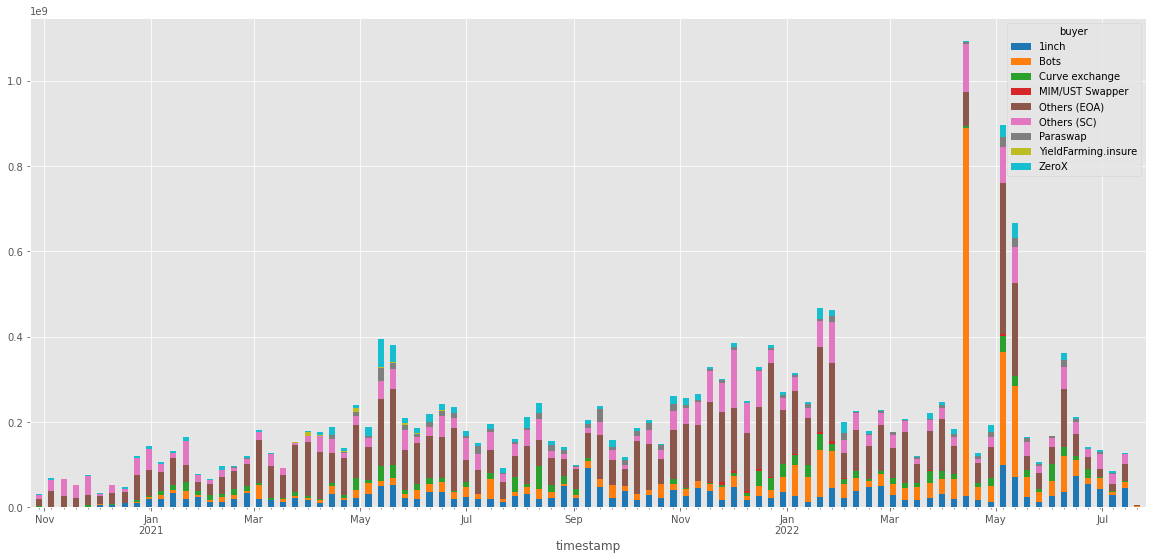

In [237]:
ax = chart_data.plot.bar(stacked=True, figsize=(20,10), colormap='tab10')

bar_width_md_default, = np.diff(mdates.date2num(chart_data.index[:2]))/2
bar_width = ax.patches[0].get_width()
bar_width_md = bar_width*bar_width_md_default/0.5
x_bars_md = mdates.date2num(chart_data.index) - bar_width_md/2
nvar = len(ax.get_legend_handles_labels()[1])
x_patches_md = np.ravel(nvar*[x_bars_md])
for patch, x_md in zip(ax.patches, x_patches_md):
    patch.set_x(x_md)
    patch.set_width(bar_width_md)
maj_loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(maj_loc)
ax.set_xticks(x_bars_md + bar_width_md/2, minor=True)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(fmt)
xmin = min(x_bars_md) - bar_width_md
xmax = max(x_bars_md) + 2*bar_width_md
ax.set_xlim(xmin, xmax)
ax.figure.autofmt_xdate(rotation=0, ha='center')

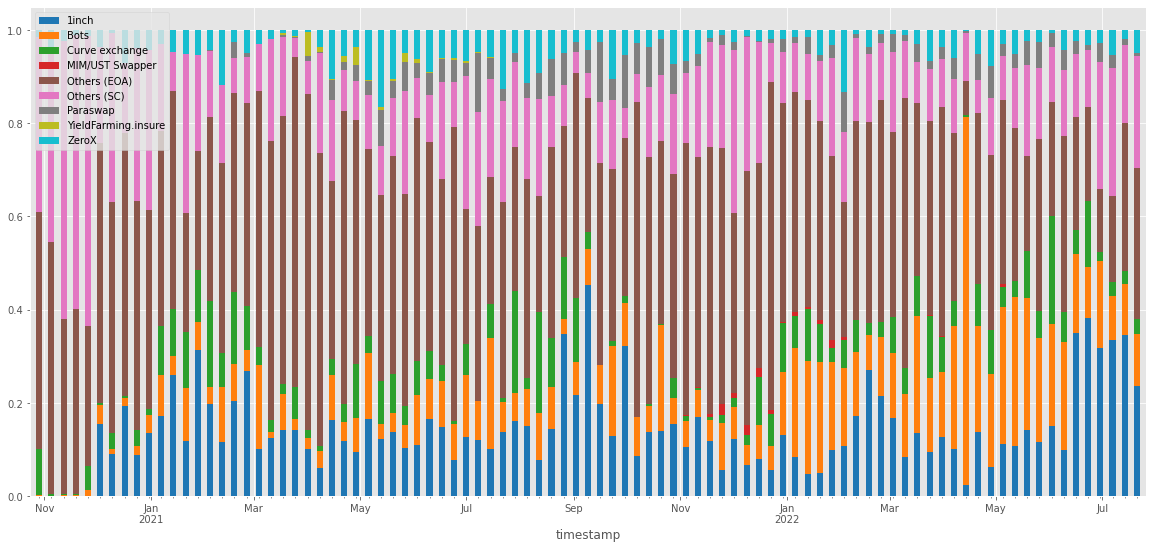

In [240]:
ax = chart_data.divide(chart_data.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(20,10), colormap='tab10')
ax.legend(loc='upper left')

bar_width_md_default, = np.diff(mdates.date2num(chart_data.index[:2]))/2
bar_width = ax.patches[0].get_width()
bar_width_md = bar_width*bar_width_md_default/0.5
x_bars_md = mdates.date2num(chart_data.index) - bar_width_md/2
nvar = len(ax.get_legend_handles_labels()[1])
x_patches_md = np.ravel(nvar*[x_bars_md])
for patch, x_md in zip(ax.patches, x_patches_md):
    patch.set_x(x_md)
    patch.set_width(bar_width_md)
maj_loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(maj_loc)
ax.set_xticks(x_bars_md + bar_width_md/2, minor=True)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(fmt)
xmin = min(x_bars_md) - bar_width_md
xmax = max(x_bars_md) + 2*bar_width_md
ax.set_xlim(xmin, xmax)
ax.figure.autofmt_xdate(rotation=0, ha='center')

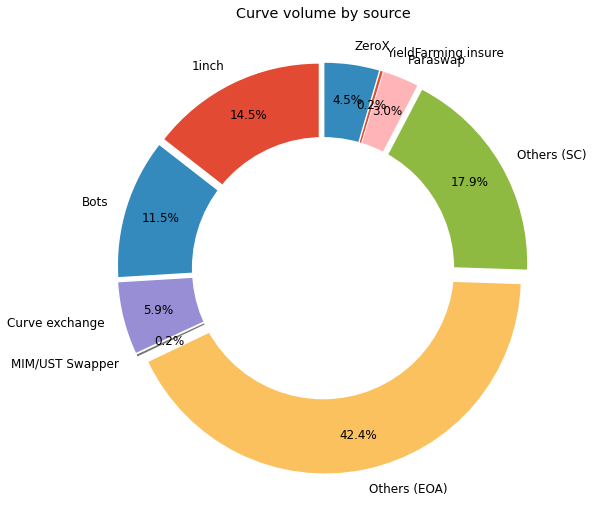

In [340]:
ax = (chart_data.divide(chart_data.sum(axis=1), axis=0).mean()*100).plot.pie(title='Curve volume by source', autopct='%1.1f%%', figsize=(9,9), fontsize=12, startangle=90, pctdistance=0.82, explode=(len(chart_data.columns))*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

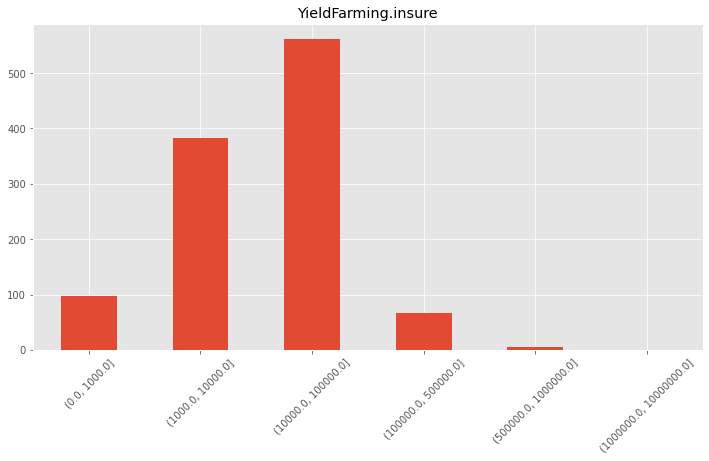

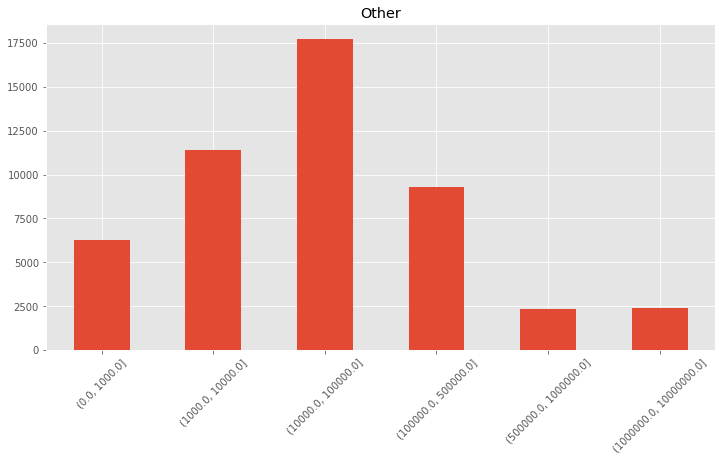

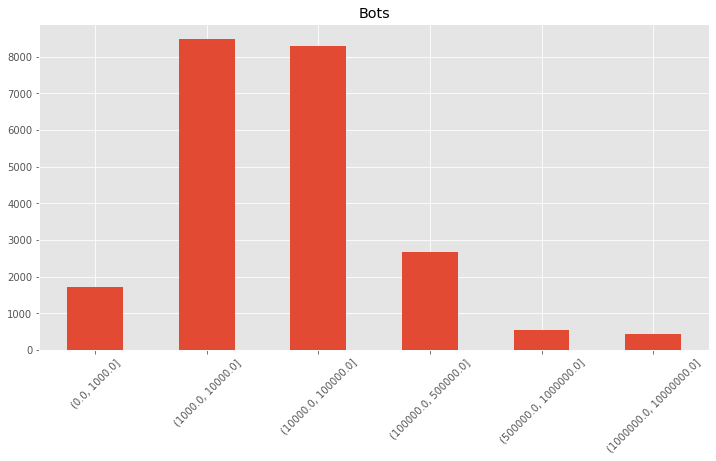

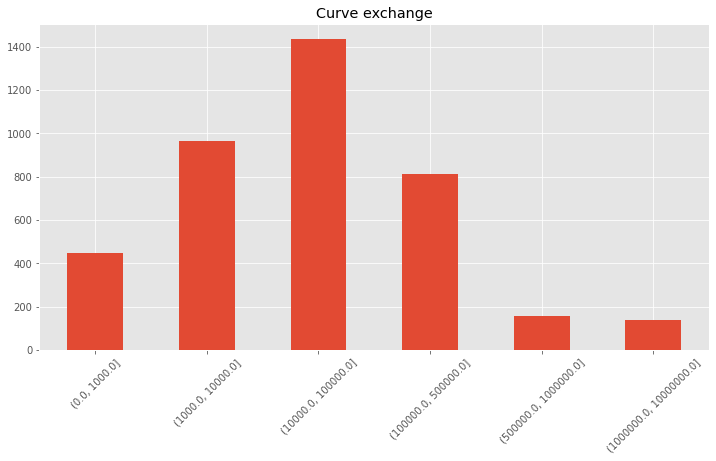

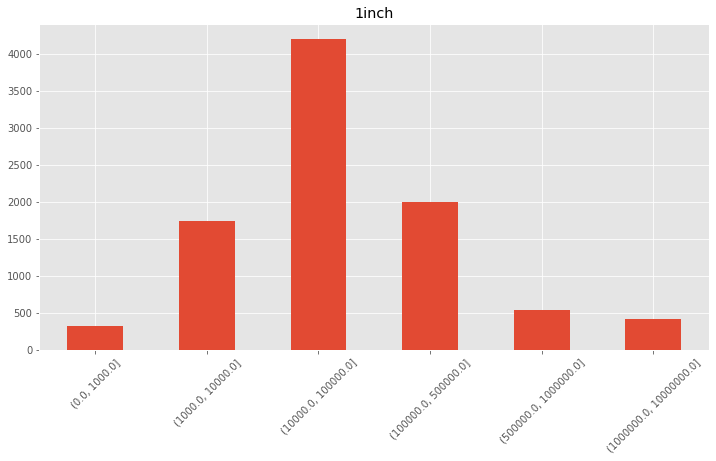

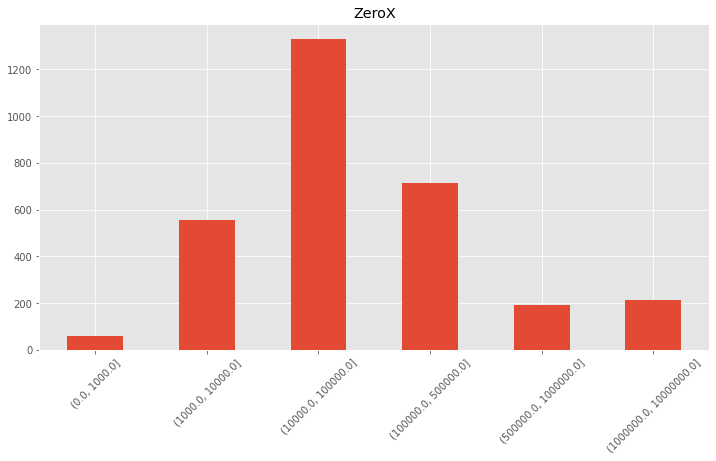

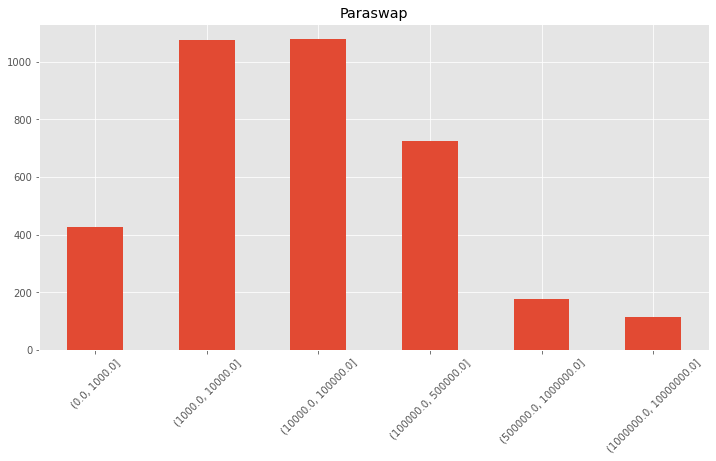

In [63]:
for buyer in df_chart['buyer'].unique().tolist():
    pd.cut(df_chart[df_chart['buyer'] == buyer]['volume'], bins=[0, 1e3, 1e4, 1e5, 5e5, 1e6, 1e7]).value_counts().sort_index().plot.bar(figsize=(12, 6), title=buyer, rot=45)
    plt.show()

In [222]:
df_distrib = df_chart.copy()
df_distrib['range'] = pd.cut(df_chart['volume'], bins=[0, 1e3, 1e4, 1e5, 5e5, 1e6, 1e7])
df_distrib

,pool,buyer,timestamp,volume,range
0,0x0043fcb34e7470130fde28198571dee092c70bd7,YieldFarming.insure,2021-06-03,1156.72,"(1000.0, 10000.0]"
1,0x0043fcb34e7470130fde28198571dee092c70bd7,YieldFarming.insure,2021-05-27,3282.18,"(1000.0, 10000.0]"
2,0x0043fcb34e7470130fde28198571dee092c70bd7,YieldFarming.insure,2021-05-27,8481.56,"(1000.0, 10000.0]"
3,0x0043fcb34e7470130fde28198571dee092c70bd7,YieldFarming.insure,2021-05-27,57272.83,"(10000.0, 100000.0]"
4,0x0043fcb34e7470130fde28198571dee092c70bd7,YieldFarming.insure,2021-05-27,1069.87,"(1000.0, 10000.0]"
...,...,...,...,...,...
92655,0xfe97d8f55884186e50aedba306ad553911a26a24,YieldFarming.insure,2021-07-22,2195.93,"(1000.0, 10000.0]"
92656,0xfe97d8f55884186e50aedba306ad553911a26a24,YieldFarming.insure,2021-07-01,71529.84,"(10000.0, 100000.0]"
92657,0xfe97d8f55884186e50aedba306ad553911a26a24,Others (EOA),2021-07-29,13018.56,"(10000.0, 100000.0]"
92658,0xfe97d8f55884186e50aedba306ad553911a26a24,YieldFarming.insure,2021-07-08,558.62,"(0.0, 1000.0]"


<AxesSubplot:xlabel='range'>

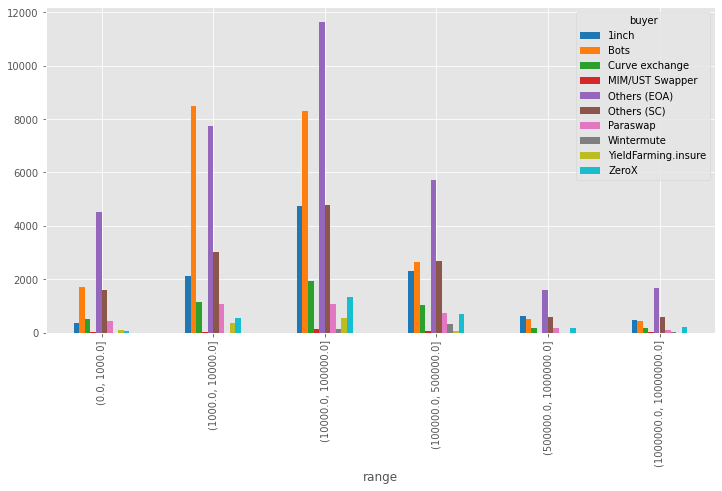

In [223]:
df_distrib.pivot_table('volume', ['range'], 'buyer', aggfunc='count').fillna(0).plot.bar(figsize=(12,6), colormap='tab10')

In [260]:
df_distrib.pivot_table('volume', ['range'], 'buyer', aggfunc='count').fillna(0)

buyer,1inch,Bots,Curve exchange,MIM/UST Swapper,Others (EOA),Others (SC),Paraswap,Wintermute,YieldFarming.insure,ZeroX
range,,,,,,,,,,
"(0.0, 1000.0]",372,1729,515,21,4521,1607,428,0,97,61
"(1000.0, 10000.0]",2131,8474,1165,48,7740,3033,1076,0,382,557
"(10000.0, 100000.0]",4737,8301,1949,126,11623,4783,1078,132,561,1329
"(100000.0, 500000.0]",2311,2659,1026,72,5700,2697,724,313,67,712
"(500000.0, 1000000.0]",622,535,187,9,1600,608,176,5,5,194
"(1000000.0, 10000000.0]",465,438,175,12,1672,609,113,26,0,213


In [369]:
s = df_distrib.pivot_table('volume', ['pool', 'range'], 'buyer', aggfunc='count').fillna(0).drop('Bots', axis=1)

In [370]:
d = s.unstack()
d.columns = ['_'.join(map(str, x)) for x in d.columns]
d

,"1inch_(0.0, 1000.0]","1inch_(1000.0, 10000.0]","1inch_(10000.0, 100000.0]","1inch_(100000.0, 500000.0]","1inch_(500000.0, 1000000.0]","1inch_(1000000.0, 10000000.0]","Curve exchange_(0.0, 1000.0]","Curve exchange_(1000.0, 10000.0]","Curve exchange_(10000.0, 100000.0]","Curve exchange_(100000.0, 500000.0]",...,"YieldFarming.insure_(10000.0, 100000.0]","YieldFarming.insure_(100000.0, 500000.0]","YieldFarming.insure_(500000.0, 1000000.0]","YieldFarming.insure_(1000000.0, 10000000.0]","ZeroX_(0.0, 1000.0]","ZeroX_(1000.0, 10000.0]","ZeroX_(10000.0, 100000.0]","ZeroX_(100000.0, 500000.0]","ZeroX_(500000.0, 1000000.0]","ZeroX_(1000000.0, 10000000.0]"
pool,,,,,,,,,,,,,,,,,,,,,
0x0043fcb34e7470130fde28198571dee092c70bd7,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
0x01fe650ef2f8e2982295489ae6adc1413bf6011f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x0212133321479b183637e52942564162bcc37c1d,0,0,0,0,0,0,0,0,0,0,...,31,2,0,0,0,0,0,0,0,0
0x0437ac6109e8a366a1f4816edf312a36952db856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x0457e0ed628143b6a6a39f6e3458153f96abb26a,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xfb9a265b5a1f52d97838ec7274a0b1442efacc87,2,7,2,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
0xfbdca68601f835b27790d98bbb8ec7f05fdeaa9b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xfd5db7463a3ab53fd211b4af195c5bccc1a03890,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,2,1,3,0,0


In [371]:
major_pools = d[d.sum(axis=1) > 150]
major_pools

,"1inch_(0.0, 1000.0]","1inch_(1000.0, 10000.0]","1inch_(10000.0, 100000.0]","1inch_(100000.0, 500000.0]","1inch_(500000.0, 1000000.0]","1inch_(1000000.0, 10000000.0]","Curve exchange_(0.0, 1000.0]","Curve exchange_(1000.0, 10000.0]","Curve exchange_(10000.0, 100000.0]","Curve exchange_(100000.0, 500000.0]",...,"YieldFarming.insure_(10000.0, 100000.0]","YieldFarming.insure_(100000.0, 500000.0]","YieldFarming.insure_(500000.0, 1000000.0]","YieldFarming.insure_(1000000.0, 10000000.0]","ZeroX_(0.0, 1000.0]","ZeroX_(1000.0, 10000.0]","ZeroX_(10000.0, 100000.0]","ZeroX_(100000.0, 500000.0]","ZeroX_(500000.0, 1000000.0]","ZeroX_(1000000.0, 10000000.0]"
pool,,,,,,,,,,,,,,,,,,,,,
0x04c90c198b2eff55716079bc06d7ccc4aa4d7512,0,0,0,0,0,0,1,11,3,0,...,0,0,0,0,0,0,0,0,0,0
0x06364f10b501e868329afbc005b3492902d6c763,5,22,111,64,6,0,15,26,38,2,...,0,0,0,0,1,31,104,24,2,0
0x06cb22615ba53e60d67bf6c341a0fd5e718e1655,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,11,15,17,10,4
0x071c661b4deefb59e2a3ddb20db036821eee8f4b,24,61,79,66,18,30,6,14,61,3,...,0,0,0,0,4,15,33,9,3,8
0x0ce6a5ff5217e38315f87032cf90686c96627caa,0,3,9,24,16,0,22,38,107,80,...,0,0,0,0,1,5,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xf9440930043eb3997fc70e1339dbb11f341de7a8,0,0,0,0,0,0,3,10,5,2,...,0,0,0,0,0,0,0,0,0,0
0xfb8814d005c5f32874391e888da6eb2fe7a27902,1,9,0,0,0,0,5,6,3,0,...,0,0,0,0,0,0,0,0,0,0
0xfb9a265b5a1f52d97838ec7274a0b1442efacc87,2,7,2,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0


In [372]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

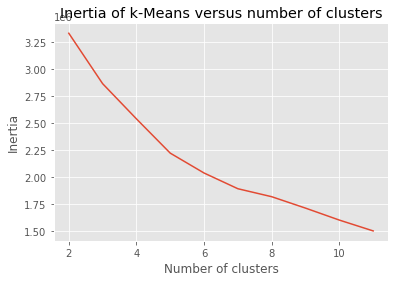

In [373]:
scores = [KMeans(n_clusters=i+2).fit(major_pools).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [374]:
pca = PCA(n_components=3)
components = pca.fit_transform(major_pools)

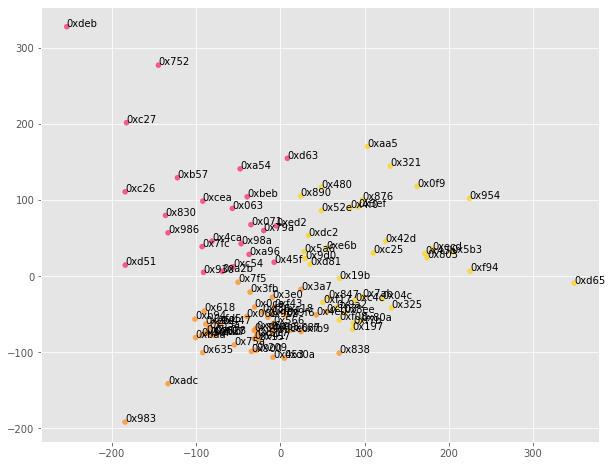

In [390]:
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(major_pools)

colors3 = ['#ffd319', '#ff2975', '#ff901f', '#424242', '#536AFA', '#8c1eff', "#F1C466","#AE85E7", "#7975F2"]
label_color = [colors3[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (10, 8))
plt.scatter(components[:,0],components[:,1], c= label_color, alpha=0.75, s=25) 
for i, page in enumerate(major_pools.index):
    plt.annotate(page[:5], (components[i,0], components[i,1]))
plt.show()

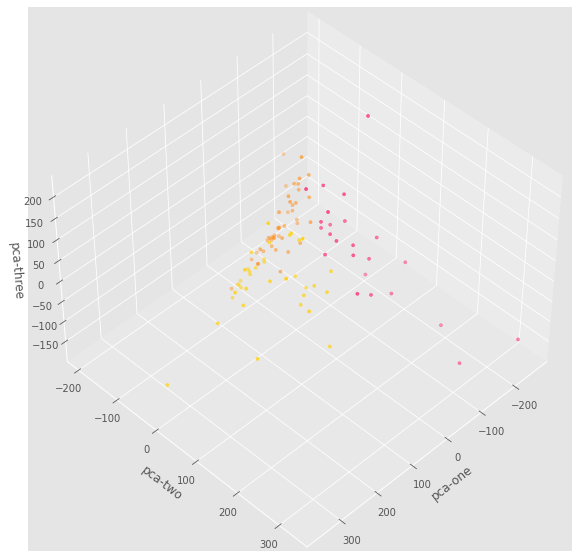

In [391]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=components[:,0], 
    ys=components[:,1], 
    zs=components[:,2], 
    c=label_color, 
    cmap='tab10',
    s=10
)
ax.view_init(45, 45)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [392]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(major_pools, X_clustered, test_size=0.25, stratify=X_clustered,random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, y_train)

y_pred_test = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_test))



              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.71      0.83      0.77         6
           2       0.85      0.92      0.88        12

    accuracy                           0.85        27
   macro avg       0.85      0.84      0.84        27
weighted avg       0.87      0.85      0.85        27



Text(0.5, 0, 'Contribution')

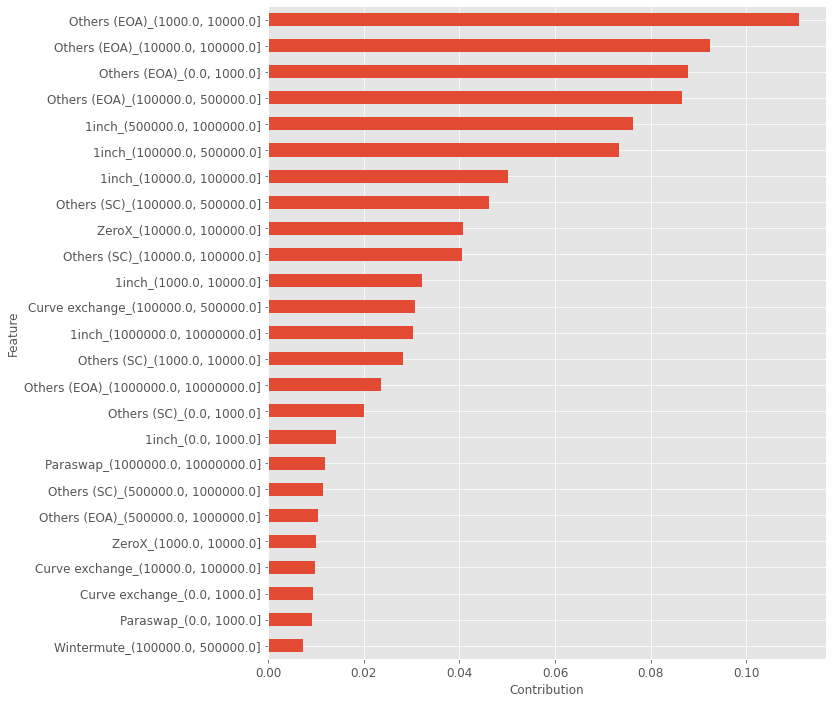

In [393]:
ax = pd.DataFrame(zip(major_pools.columns, random_forest.feature_importances_)).set_index(0).sort_values(1)[-25:].plot.barh(fontsize=12, figsize=(10,12), legend=False)
ax.set_ylabel('Feature')
ax.set_xlabel('Contribution')

<AxesSubplot:xlabel='cluster', ylabel='value'>

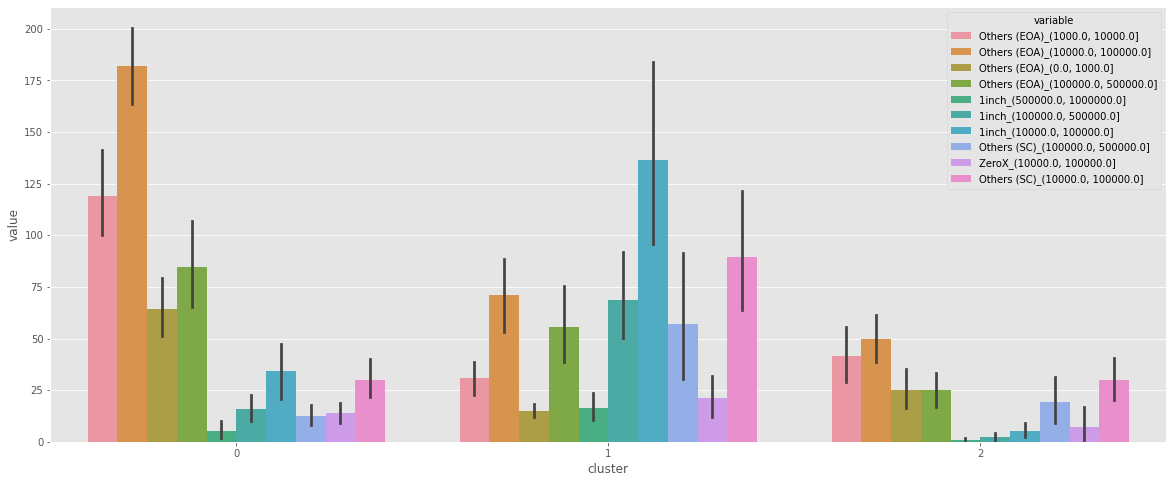

In [394]:
data = np.array([random_forest.feature_importances_, major_pools.columns.tolist()]).T
columns = list(pd.DataFrame(data, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .head(10).Feature.values) 
df_scaled = major_pools.copy()
df_scaled.columns = major_pools.columns
df_scaled['cluster'] = kmeans.labels_
tidy = df_scaled[columns+['cluster']].melt(id_vars='cluster')
plt.figure(figsize = (20, 8))
sns.barplot(x='cluster', y='value', hue='variable', data=tidy)

In [398]:
names = grt_query('{pools(first:1000){id name}}')

In [407]:
names = {pool['id']: pool['name'] for pool in names['pools']}

In [412]:
[names[pool] for pool in major_pools[X_clustered == 0].index.to_list()]

['Curve.fi Factory Plain Pool: Badger Locked CVX',
 'Curve.fi USDN/3Crv',
 'Curve.fi Factory Plain Pool: ApeUSD-FRAX',
 'Curve.fi Factory Plain Pool: ibEUR/sEUR',
 'Curve.fi Factory Crypto Pool: STG/USDC',
 'Curve.fi Factory USD Metapool: STABLEx',
 'Curve.fi HUSD/3Crv',
 'Curve.fi USDP/3Crv',
 'Curve.fi Factory USD Metapool: Alchemix USD',
 'Curve.fi Factory USD Metapool: Binance USD',
 'Curve.fi GUSD/3Crv',
 'Curve.fi cDAI/cUSDC/USDT',
 'Curve.fi Factory USD Metapool: Magic Internet Money 3Pool',
 'Curve.fi Factory USD Metapool: USDM',
 'Curve.fi Factory USD Metapool: USDV',
 'Curve.fi DUSD/3Crv',
 'Curve.fi Factory Crypto Pool: Goldfinch FIDU/USDC',
 'Curve.fi MUSD/3Crv',
 'Curve.fi Factory USD Metapool: Origin Dollar',
 'Curve.fi UST/3Crv',
 'Curve.fi Factory USD Metapool: PUSd',
 'Curve.fi Factory USD Metapool: DOLA 3CRV Curve Metapool',
 'Curve.fi Factory Crypto Pool: SILO/FRAX',
 'Curve.fi Factory Plain Pool: cvxCRV',
 'Curve.fi Factory USD Metapool: DOLA-3pool Curve LP',
 'Curv

In [413]:
[names[pool] for pool in major_pools[X_clustered == 1].index.to_list()]

['Curve.fi DAI/USDC/USDT/PAX',
 'Curve.fi bBTC/sbtcCRV',
 'Curve.fi yDAI/yUSDC/yUSDT/yTUSD',
 'Curve.fi hBTC/wBTC',
 'Curve T-ETH',
 'Curve.fi yDAI/yUSDC/yUSDT/yBUSD',
 'Curve.fi renBTC/wBTC/sBTC',
 'Curve CRV-ETH',
 'Curve.fi renBTC/wBTC',
 'Curve SPELL-ETH',
 'Curve EURS-USDC',
 'Curve.fi cDAI/cUSDC',
 'Curve.fi DAI/USDC/USDT/sUSD',
 'Curve.fi ETH/aETH',
 'Curve CVX-ETH',
 'Curve.fi DAI/USDC/USDT',
 'Curve.fi Factory Crypto Pool: YFI/ETH',
 'Curve.fi Factory USD Metapool: Paxos Dollar (USDP)',
 'Curve.fi ETH/sETH',
 'Curve.fi Factory USD Metapool: wormhole v2 UST-3Pool',
 'Curve.fi USD-BTC-ETH',
 'Curve.fi Factory USD Metapool: Frax',
 'Curve.fi aDAI/aUSDC/aUSDT',
 'Curve.fi Factory USD Metapool: Liquity']